In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Dropout,
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import cv2
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Function to parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize variables for the image details
    label = None

    # Parse XML to get the label
    for member in root.findall("object"):
        label = member.find("name").text
        # Assuming we only need the label, not bounding box coordinates

    return label

In [10]:
# Paths
annotations_dir = "1/annotations"
images_dir = "1/images/"

# Initialize lists to hold data
image_data = []
labels = []

# Loop over each XML file in the annotations folder
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith(".xml"):
        # Parse the XML to get the label
        xml_path = os.path.join(annotations_dir, xml_file)
        label = parse_xml(xml_path)

        # Corresponding image file
        image_file = xml_file.replace(".xml", ".png")
        image_path = os.path.join(images_dir, image_file)

        # Check if the image file exists
        if os.path.exists(image_path):
            # Read and resize image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(
                image, cv2.COLOR_BGR2RGB
            )  # Ensure 3 channels and correct color order for Keras
            image = cv2.resize(image, (128, 128))  # Resize to 128x128

            # Append data to lists
            image_data.append(image)  # Keep image as 2D array
            labels.append(label)

# Convert to numpy arrays
X = np.array(image_data)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

print(f"Shape of X: {X.shape}")
print(f"Shape of y_categorical: {y_categorical.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_encoder.classes_}")

Shape of X: (853, 128, 128, 3)
Shape of y_categorical: (853, 3)
Number of classes: 3
Class labels: ['mask_weared_incorrect' 'with_mask' 'without_mask']


Sample image label: without_mask


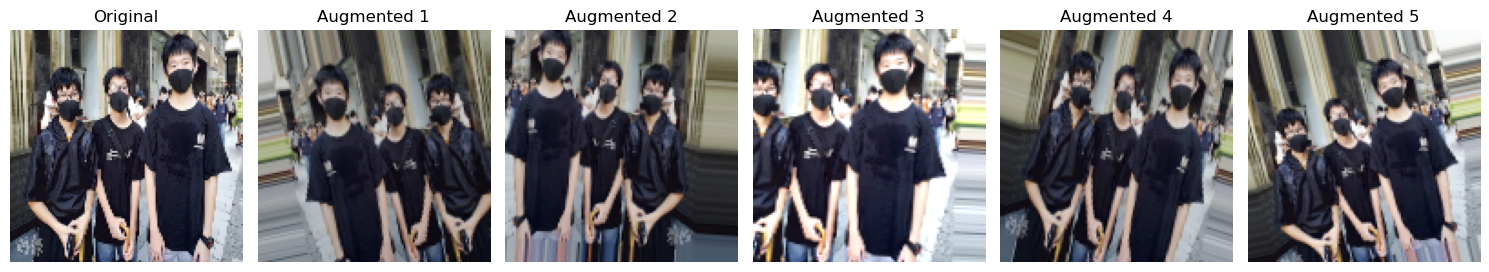

In [11]:
# Create an image data generator with augmentation for training data
data_augmentation = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,  # randomly shift images vertically by up to 20% of height
    shear_range=0.2,  # shear angle in counter-clockwise direction in degrees
    zoom_range=0.2,  # randomly zoom in on images by up to 20%
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode="nearest",  # strategy for filling in newly created pixels
    brightness_range=[0.8, 1.2],  # randomly adjust brightness
)


# Define a function to visualize augmented images
def visualize_augmentation(image, num_samples=5):
    # Expand dimensions to make it a batch of size 1
    img = np.expand_dims(image, axis=0)

    # Initialize a figure
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    # Generate and plot augmented images
    aug_iter = data_augmentation.flow(img, batch_size=1)
    for i in range(num_samples):
        batch = aug_iter.next()
        aug_img = batch[0].astype("uint8")
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(aug_img)
        plt.title(f"Augmented {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize augmentation on a sample image if there are any images loaded
if len(image_data) > 0:
    sample_idx = np.random.randint(0, len(image_data))
    sample_image = image_data[sample_idx]
    sample_label = labels[sample_idx]
    print(f"Sample image label: {sample_label}")
    visualize_augmentation(sample_image)

## Prepare Data for MobileNetV2
### Define and Compile MobileNetV2 Model

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# num_classes should be defined from the label encoding step in the previous cell

# Load MobileNetV2 base model, excluding the top classification layer
base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(128, 128, 3)
)

# Freeze the layers of the base model (so we only train our custom head initially)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(
    x
)  # Added l2 regularization
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(
    x
)  # num_classes is from the data loading cell

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

## Data Augmentation

Data augmentation is a technique used to artificially expand the training dataset by creating modified versions of existing images. This helps to reduce overfitting, improves model generalization, and is especially helpful when dealing with limited data or class imbalance.

Common augmentations include:
- Rotation: Rotating the image by a small degree
- Width/Height shifting: Moving the image horizontally/vertically
- Shearing: Slanting the image
- Zooming: Zooming in or out
- Horizontal flipping: Mirroring the image horizontally
- Brightness/contrast adjustment: Changing the brightness levels

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Split data into training and validation sets
# Ensure X contains the images and y_categorical contains the one-hot encoded labels
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Apply MobileNetV2 preprocessing
# MobileNetV2 expects pixel values in the range [-1, 1]
# The preprocess_input function handles this.
X_train_processed = preprocess_input(X_train.astype("float32"))
X_val_processed = preprocess_input(X_val.astype("float32"))

# Set up data augmentation - only for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_input,  # Apply MobileNetV2 preprocessing
)

# Validation data should not be augmented, only preprocessed
validation_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train.astype("float32"), y_train, batch_size=32)

validation_generator = validation_datagen.flow(X_val_processed, y_val, batch_size=32)

print(f"X_train shape: {X_train.shape}")
print(f"X_val_processed shape: {X_val_processed.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print("Training data will be augmented on-the-fly during training")

X_train shape: (682, 128, 128, 3)
X_val_processed shape: (171, 128, 128, 3)
y_train shape: (682, 3)
y_val shape: (171, 3)
Training data will be augmented on-the-fly during training


## Addressing Class Imbalance with Class Weights

In [ ]:
from sklearn.utils import class_weight

# Convert one-hot encoded y_train back to integer class indices
y_train_indices = np.argmax(y_train, axis=1)

# Calculate class weights from integer labels
class_weights_array = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_indices), y=y_train_indices
)

# Convert to dictionary format required by Keras
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights:", class_weights_dict)

Class weights: {0: 7.839080459770115, 1: 0.44838921761998685, 2: 1.5570776255707763}


In [17]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1
)
model_checkpoint = ModelCheckpoint(
    "best_mask_detector_mobilenetv2.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
)

epochs = 50
batch_size = 32

# Calculate steps per epoch and validation steps
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Make sure we have at least one step
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

print("Starting training with augmentation and class weights...")
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights_dict,
)

print("Training complete.")

Starting training with augmentation and class weights...
Epoch 1/50
21/21 [==============================] - 17s 635ms/step - loss: 4.0110 - accuracy: 0.4215 - val_loss: 2.7978 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 5s 246ms/step - loss: 3.1309 - accuracy: 0.5446 - val_loss: 2.5209 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 5s 244ms/step - loss: 2.7185 - accuracy: 0.5015 - val_loss: 2.3735 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 5s 237ms/step - loss: 2.3749 - accuracy: 0.6031 - val_loss: 2.2014 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 5s 224ms/step - loss: 2.2128 - accuracy: 0.5492 - val_loss: 2.0771 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 5s 250ms/step - loss: 2.0957 - accuracy: 0.6462 - val_loss: 1.9092 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 7/50
2

## Evaluate the Model


Validation Loss: 0.9598
Validation Accuracy: 0.8062


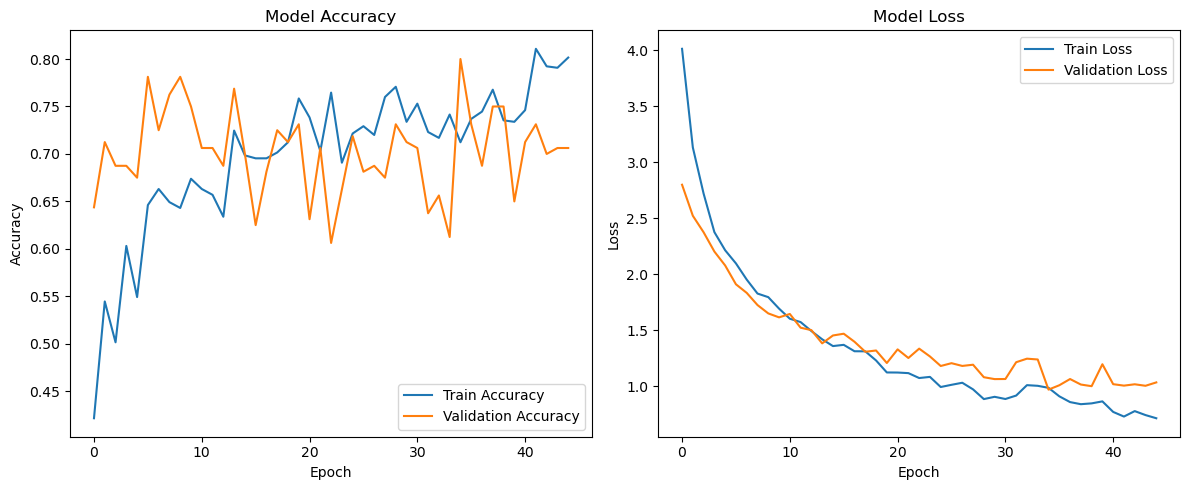

6/6 [==============================] - 2s 142ms/step

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.75      0.43      0.55         7
            with_mask       0.88      0.86      0.87       127
         without_mask       0.58      0.68      0.62        37

             accuracy                           0.80       171
            macro avg       0.74      0.65      0.68       171
         weighted avg       0.81      0.80      0.80       171


Confusion Matrix:
[[  3   3   1]
 [  1 109  17]
 [  0  12  25]]


In [18]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator, steps=validation_steps, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Further evaluation (e.g., classification report, confusion matrix)
from sklearn.metrics import classification_report, confusion_matrix

# For evaluation metrics, we need to get the actual predictions on validation data
y_pred_probabilities = model.predict(X_val_processed)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_true_classes = np.argmax(
    y_val, axis=1
)  # Convert one-hot encoded y_val back to class indices

# Ensure label_encoder is available from the data loading cell
if "label_encoder" in globals() and hasattr(label_encoder, "classes_"):
    print("\nClassification Report:")
    print(
        classification_report(
            y_true_classes, y_pred_classes, target_names=label_encoder.classes_
        )
    )

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true_classes, y_pred_classes))
else:
    print("\nClassification Report (numeric labels):")
    print(classification_report(y_true_classes, y_pred_classes))
    print("\nConfusion Matrix (numeric labels):")
    print(confusion_matrix(y_true_classes, y_pred_classes))
    print(
        "\nNote: 'label_encoder' not found or not fitted. Class names will not be shown in the report."
    )

## Fine-tuning


Number of layers in the base model:  154
Layer block_15_depthwise_relu unfrozen.
Layer block_15_project unfrozen.
Layer block_15_project_BN unfrozen.
Layer block_15_add unfrozen.
Layer block_16_expand unfrozen.
Layer block_16_expand_BN unfrozen.
Layer block_16_expand_relu unfrozen.
Layer block_16_depthwise unfrozen.
Layer block_16_depthwise_BN unfrozen.
Layer block_16_depthwise_relu unfrozen.
Layer block_16_project unfrozen.
Layer block_16_project_BN unfrozen.
Layer Conv_1 unfrozen.
Layer Conv_1_bn unfrozen.
Layer out_relu unfrozen.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                

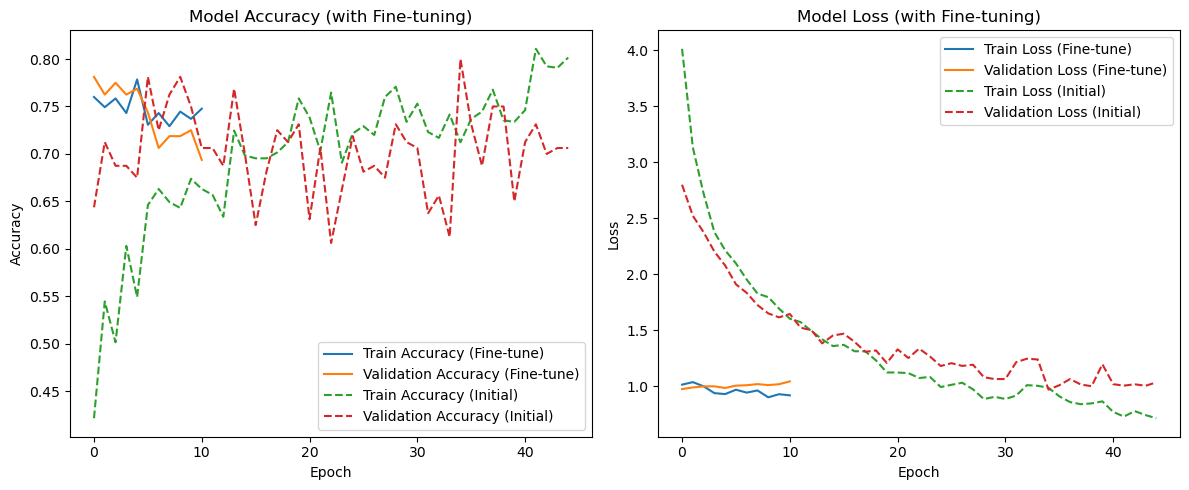

In [19]:
print("Number of layers in the base model: ", len(base_model.layers))
# Unfreeze from a certain layer onwards. The exact number depends on the model architecture and experimentation.
# For MobileNetV2, you might start by unfreezing the last block or two.
fine_tune_at = -15

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
    print(f"Layer {layer.name} unfrozen.")

# Re-compile the model with a very low learning rate for fine-tuning
optimizer_fine_tune = Adam(learning_rate=1e-5)  # Very low learning rate for fine-tuning
model.compile(
    optimizer=optimizer_fine_tune, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()  # Check the updated trainable parameters

# Define checkpoint callback for fine-tuning
model_checkpoint_finetune = ModelCheckpoint(
    "best_mask_detector_mobilenetv2_finetuned.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
)

print("\nStarting fine-tuning with augmentation and class weights...")
# You might want to train for fewer epochs during fine-tuning
fine_tune_epochs = 20
total_epochs = history.epoch[-1] + 1 + fine_tune_epochs

history_fine_tune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,  # Start from where the last training stopped
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[
        early_stopping,
        reduce_lr,
        model_checkpoint_finetune,  # Added checkpoint callback for fine-tuning
    ],
    class_weight=class_weights_dict,
)

print("Fine-tuning complete.")

# Evaluate after fine-tuning
loss_ft, accuracy_ft = model.evaluate(
    validation_generator, steps=validation_steps, verbose=0
)
print(f"Fine-tuned Validation Loss: {loss_ft:.4f}")
print(f"Fine-tuned Validation Accuracy: {accuracy_ft:.4f}")

# Plot fine-tuning history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history["accuracy"], label="Train Accuracy (Fine-tune)")
plt.plot(
    history_fine_tune.history["val_accuracy"], label="Validation Accuracy (Fine-tune)"
)
plt.plot(
    history.history["accuracy"], label="Train Accuracy (Initial)", linestyle="--"
)  # Plot initial history too
plt.plot(
    history.history["val_accuracy"],
    label="Validation Accuracy (Initial)",
    linestyle="--",
)
plt.title("Model Accuracy (with Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history["loss"], label="Train Loss (Fine-tune)")
plt.plot(history_fine_tune.history["val_loss"], label="Validation Loss (Fine-tune)")
plt.plot(history.history["loss"], label="Train Loss (Initial)", linestyle="--")
plt.plot(history.history["val_loss"], label="Validation Loss (Initial)", linestyle="--")
plt.title("Model Loss (with Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Load and Evaluate Best Models

In [20]:
from tensorflow.keras.models import load_model

# Load the best model saved during the fine-tuning phase
try:
    best_finetuned_model = load_model("best_mask_detector_mobilenetv2_finetuned.keras")
    loss_best_ft, accuracy_best_ft = best_finetuned_model.evaluate(
        validation_generator, steps=validation_steps, verbose=0
    )
    print(
        f"Best Fine-tuned Model (from checkpoint) Validation Loss: {loss_best_ft:.4f}"
    )
    print(
        f"Best Fine-tuned Model (from checkpoint) Validation Accuracy: {accuracy_best_ft:.4f}"
    )

    # Generate classification report for the best fine-tuned model
    ft_preds = best_finetuned_model.predict(X_val_processed)
    ft_pred_classes = np.argmax(ft_preds, axis=1)
    ft_true_classes = np.argmax(y_val, axis=1)

    print("\nClassification Report for Best Fine-tuned Model:")
    print(
        classification_report(
            ft_true_classes, ft_pred_classes, target_names=label_encoder.classes_
        )
    )

    print("\nConfusion Matrix for Best Fine-tuned Model:")
    print(confusion_matrix(ft_true_classes, ft_pred_classes))

except (OSError, IOError) as e:
    print(f"Could not load fine-tuned model: {e}")

# Also, load and evaluate the best model from the initial training for comparison
try:
    best_initial_model = load_model("best_mask_detector_mobilenetv2.keras")
    loss_initial, accuracy_initial = best_initial_model.evaluate(
        validation_generator, steps=validation_steps, verbose=0
    )
    print(f"\nBest Initial Model (from checkpoint) Validation Loss: {loss_initial:.4f}")
    print(
        f"Best Initial Model (from checkpoint) Validation Accuracy: {accuracy_initial:.4f}"
    )

    # Generate classification report for the best initial model
    initial_preds = best_initial_model.predict(X_val_processed)
    initial_pred_classes = np.argmax(initial_preds, axis=1)

    print("\nClassification Report for Best Initial Model:")
    print(
        classification_report(
            ft_true_classes, initial_pred_classes, target_names=label_encoder.classes_
        )
    )

    print("\nConfusion Matrix for Best Initial Model:")
    print(confusion_matrix(ft_true_classes, initial_pred_classes))

except (OSError, IOError) as e:
    print(f"Could not load initial model: {e}")

# Compare the models
if "accuracy_best_ft" in locals() and "accuracy_initial" in locals():
    if accuracy_best_ft > accuracy_initial:
        print("\nThe fine-tuned model performs better!")
        best_model = best_finetuned_model
    else:
        print("\nThe initial model performs better!")
        best_model = best_initial_model

    print(f"Best model accuracy: {max(accuracy_best_ft, accuracy_initial):.4f}")

Best Fine-tuned Model (from checkpoint) Validation Loss: 0.9605
Best Fine-tuned Model (from checkpoint) Validation Accuracy: 0.7875
6/6 [==============================] - 2s 126ms/step

Classification Report for Best Fine-tuned Model:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.60      0.43      0.50         7
            with_mask       0.88      0.83      0.85       127
         without_mask       0.54      0.68      0.60        37

             accuracy                           0.78       171
            macro avg       0.67      0.64      0.65       171
         weighted avg       0.79      0.78      0.78       171


Confusion Matrix for Best Fine-tuned Model:
[[  3   3   1]
 [  2 105  20]
 [  0  12  25]]

Best Initial Model (from checkpoint) Validation Loss: 0.9860
Best Initial Model (from checkpoint) Validation Accuracy: 0.8000
6/6 [==============================] - 2s 111ms/step

Classification Report for Best Initial Model:
   

## Analyzing the Impact of Addressing Class Imbalance

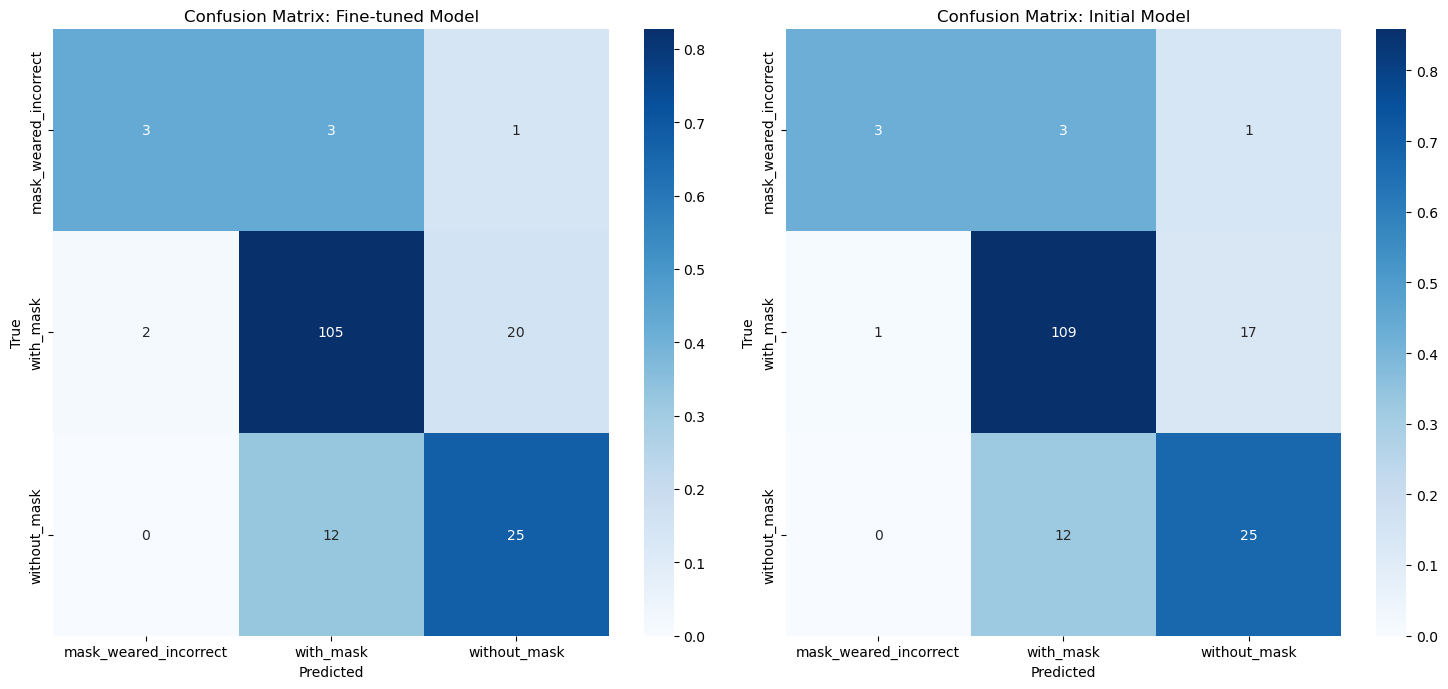


Performance on minority class ('mask_weared_incorrect'):
Fine-tuned model: Precision = 0.6000, Recall = 0.4286, F1 = 0.5000
Initial model   : Precision = 0.7500, Recall = 0.4286, F1 = 0.5455

Improvement in recall for minority class: 0.00%

Overall F1 scores:
Fine-tuned model: Macro F1 = 0.6509, Weighted F1 = 0.7823
Initial model   : Macro F1 = 0.6797, Weighted F1 = 0.8026

Improvement in macro F1 score: -4.24%


In [21]:
# This cell helps analyze if using class weights improved performance on minority classes

# Only run this if both models were successfully loaded
if "best_finetuned_model" in locals() and "best_initial_model" in locals():
    # Plot the confusion matrices for better visualization
    import seaborn as sns

    plt.figure(figsize=(15, 7))

    # Plot confusion matrix for fine-tuned model
    plt.subplot(1, 2, 1)
    ft_cm = confusion_matrix(ft_true_classes, ft_pred_classes)
    ft_cm_normalized = (
        ft_cm.astype("float") / ft_cm.sum(axis=1)[:, np.newaxis]
    )  # Normalize

    sns.heatmap(
        ft_cm_normalized,
        annot=ft_cm,  # Show raw counts inside cells
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.title("Confusion Matrix: Fine-tuned Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Plot confusion matrix for initial model
    plt.subplot(1, 2, 2)
    initial_cm = confusion_matrix(ft_true_classes, initial_pred_classes)
    initial_cm_normalized = (
        initial_cm.astype("float") / initial_cm.sum(axis=1)[:, np.newaxis]
    )  # Normalize

    sns.heatmap(
        initial_cm_normalized,
        annot=initial_cm,  # Show raw counts inside cells
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.title("Confusion Matrix: Initial Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.tight_layout()
    plt.show()

    # Compare performance on the minority class ('mask_weared_incorrect')
    minority_class_idx = np.where(label_encoder.classes_ == "mask_weared_incorrect")[0][
        0
    ]

    # Calculate metrics for the minority class
    ft_precision = (
        ft_cm[minority_class_idx, minority_class_idx]
        / ft_cm[:, minority_class_idx].sum()
        if ft_cm[:, minority_class_idx].sum() > 0
        else 0
    )
    ft_recall = (
        ft_cm[minority_class_idx, minority_class_idx]
        / ft_cm[minority_class_idx, :].sum()
        if ft_cm[minority_class_idx, :].sum() > 0
        else 0
    )
    ft_f1 = (
        2 * (ft_precision * ft_recall) / (ft_precision + ft_recall)
        if (ft_precision + ft_recall) > 0
        else 0
    )

    initial_precision = (
        initial_cm[minority_class_idx, minority_class_idx]
        / initial_cm[:, minority_class_idx].sum()
        if initial_cm[:, minority_class_idx].sum() > 0
        else 0
    )
    initial_recall = (
        initial_cm[minority_class_idx, minority_class_idx]
        / initial_cm[minority_class_idx, :].sum()
        if initial_cm[minority_class_idx, :].sum() > 0
        else 0
    )
    initial_f1 = (
        2 * (initial_precision * initial_recall) / (initial_precision + initial_recall)
        if (initial_precision + initial_recall) > 0
        else 0
    )

    print("\nPerformance on minority class ('mask_weared_incorrect'):")
    print(
        f"Fine-tuned model: Precision = {ft_precision:.4f}, Recall = {ft_recall:.4f}, F1 = {ft_f1:.4f}"
    )
    print(
        f"Initial model   : Precision = {initial_precision:.4f}, Recall = {initial_recall:.4f}, F1 = {initial_f1:.4f}"
    )

    # Improvement percentage
    if initial_recall > 0:
        recall_improvement = ((ft_recall - initial_recall) / initial_recall) * 100
        print(f"\nImprovement in recall for minority class: {recall_improvement:.2f}%")

    # Analyze macro vs weighted F1 scores
    from sklearn.metrics import f1_score

    ft_macro_f1 = f1_score(ft_true_classes, ft_pred_classes, average="macro")
    ft_weighted_f1 = f1_score(ft_true_classes, ft_pred_classes, average="weighted")

    initial_macro_f1 = f1_score(ft_true_classes, initial_pred_classes, average="macro")
    initial_weighted_f1 = f1_score(
        ft_true_classes, initial_pred_classes, average="weighted"
    )

    print("\nOverall F1 scores:")
    print(
        f"Fine-tuned model: Macro F1 = {ft_macro_f1:.4f}, Weighted F1 = {ft_weighted_f1:.4f}"
    )
    print(
        f"Initial model   : Macro F1 = {initial_macro_f1:.4f}, Weighted F1 = {initial_weighted_f1:.4f}"
    )

    if initial_macro_f1 > 0:
        macro_improvement = ((ft_macro_f1 - initial_macro_f1) / initial_macro_f1) * 100
        print(f"\nImprovement in macro F1 score: {macro_improvement:.2f}%")